In [1]:
from ubibetter.models.compute_fraction  import compute_fraction
from ubibetter.utils.data.get_neigbours import get_neighbours
from ubibetter.models.compute_fraction import compute_fraction
from betbrain.manager.data_manager import data_manager

import pandas as pd
import numpy as np

from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
dm = data_manager(sport='Baseball')

In [3]:
data = dm.__get_data__()

In [4]:
data.head()

odds        \
                                                                   0     1   
MatchDate  HomeTeam          AwayTeam          bkmr                          
2008-09-10 Seattle Mariners  Texas Rangers     pinnacle_op_ha_  2.69  1.56   
2008-09-14 Houston Astros    Chicago Cubs      pinnacle_op_ha_  3.36  1.39   
2008-09-28 Chicago White Sox Cleveland Indians pinnacle_op_ha_  1.97  1.92   
           Milwaukee Brewers Chicago Cubs      pinnacle_op_ha_  2.11  1.81   
           New York Mets     Miami Marlins     pinnacle_op_ha_  2.04  1.88   

                                                                prob        \
                                                                   0     1   
MatchDate  HomeTeam          AwayTeam          bkmr                          
2008-09-10 Seattle Mariners  Texas Rangers     pinnacle_op_ha_  0.37  0.63   
2008-09-14 Houston Astros    Chicago Cubs      pinnacle_op_ha_  0.29  0.71   
2008-09-28 Chicago White Sox Cleveland Indians pinnacle_op_ha_  0.49  0.51   
           Milwaukee Brewers Chicago Cubs      pinnacle_op_ha_  0.46  0.54   
           New York Mets     Miami Marlins     pinnacle_op_ha_  0.48  0.52   

                                                                 book FTR  
                                                                           
MatchDate  HomeTeam          AwayTeam          bkmr                        
2008-09-10 Seattle Mariners  Texas Rangers     pinnacle_op_ha_  0.013   0  
2008-09-14 Houston Astros    Chicago Cubs      pinnacle_op_ha_  0.017   1  
2008-09-28 Chicago White Sox Cleveland Indians pinnacle_op_ha_  0.028   0  
           Milwaukee Brewers Chicago Cubs      pinnacle_op_ha_  0.026   1  
           New York Mets     Miami Marlins     pinnacle_op_ha_  0.022   1

In [5]:
train = data[data.index.get_level_values(0) < datetime(2017, 3, 1)]
test  = data[data.index.get_level_values(0) > datetime(2017, 3, 1)]

In [6]:
matrix = dm.ubibetter.get_matrix(train,[('prob', 0), ('prob', 1), 'FTR'])
matrix = matrix[matrix.sum(axis=1) > 250]

/Users/Gabriele/Library/Mobile Documents/com~apple~CloudDocs/Kellify/Projects/ubipy/env/lib/python3.7/site-packages/pandas/core/generic.py:3947: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


In [7]:
matrix.head()

FTR                      0      1
(prob, 0) (prob, 1)              
0.28      0.72        88.0  196.0
0.29      0.71        85.0  249.0
0.30      0.70       173.0  476.0
0.31      0.69       262.0  542.0
0.32      0.68       348.0  737.0

In [9]:
vicini = test.prob.apply(get_neighbours, axis=1).rename('NN').to_frame()
probs  = vicini.apply(dm.ubibetter.__compute_probs_avg__, axis=1, args=[matrix])
probs.columns = pd.MultiIndex.from_tuples([('KLFY', c) for c in probs.columns])

In [10]:
aux = pd.concat([test.odds.stack().rename('odd'), probs.KLFY.stack().rename('prob')], axis=1, join='inner')
aux = aux.reset_index(level=4).merge(test['FTR'], right_index=True, left_index=True)

In [11]:
aux.head(6)

level_4   odd  \
MatchDate  HomeTeam       AwayTeam      bkmr                           
2017-02-24 Boston Red Sox New York Mets 10bet_op_ha_         0  2.05   
                                        10bet_op_ha_         1  1.74   
                                        5dimes_op_ha_        0  2.08   
                                        5dimes_op_ha_        1  1.81   
                                        bet365_op_ha_        0  2.10   
                                        bet365_op_ha_        1  1.76   

                                                           prob  FTR  
MatchDate  HomeTeam       AwayTeam      bkmr                          
2017-02-24 Boston Red Sox New York Mets 10bet_op_ha_   0.472745    0  
                                        10bet_op_ha_   0.527255    0  
                                        5dimes_op_ha_  0.482115    0  
                                        5dimes_op_ha_  0.517885    0  
                                        bet365_op_ha_  0.472745    0  
                                        bet365_op_ha_  0.527255    0

In [12]:
frac = aux.groupby(level=[0,1,2,3]).apply(compute_fraction)

In [13]:
frac = frac.stack().rename('frac').to_frame()

In [14]:
aux  = pd.concat([aux.set_index('level_4', append=True), frac.round(4)], axis=1).reset_index(level=4)

In [15]:
def perform_simulation(x):
    if x['level_4'] == x['FTR']:
        return (x['odd'] - 1) * x['frac']
    elif x['level_4'] != x['FTR']:
        return -x['frac']

In [16]:
aux['margin'] = aux.apply(perform_simulation, axis=1)

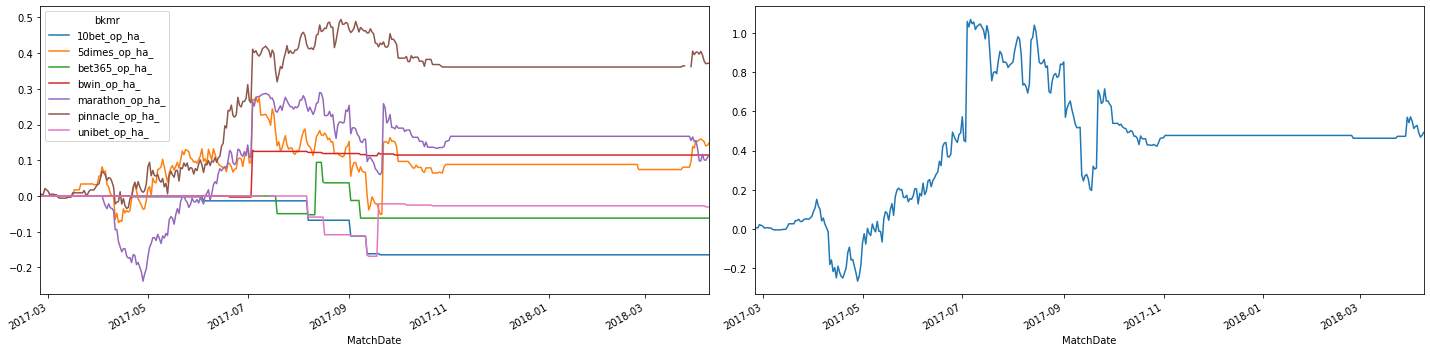

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
aux.margin.groupby(level=[0,3]).sum().unstack().cumsum().plot(ax=ax[0])
aux.margin.groupby(level=[0]).sum().cumsum().plot(ax=ax[1])
plt.tight_layout()

In [61]:
aux.head()

level_4   odd  \
MatchDate  HomeTeam       AwayTeam      bkmr                           
2017-02-24 Boston Red Sox New York Mets 10bet_op_ha_         0  2.05   
                                        10bet_op_ha_         1  1.74   
                                        5dimes_op_ha_        0  2.08   
                                        5dimes_op_ha_        1  1.81   
                                        bet365_op_ha_        0  2.10   

                                                           prob  FTR    frac  \
MatchDate  HomeTeam       AwayTeam      bkmr                                   
2017-02-24 Boston Red Sox New York Mets 10bet_op_ha_   0.472745    0  0.0000   
                                        10bet_op_ha_   0.527255    0  0.0000   
                                        5dimes_op_ha_  0.482115    0  0.0026   
                                        5dimes_op_ha_  0.517885    0  0.0000   
                                        bet365_op_ha_  0.472745    0  0.0000   

                                                         margin  
MatchDate  HomeTeam       AwayTeam      bkmr                     
2017-02-24 Boston Red Sox New York Mets 10bet_op_ha_   0.000000  
                                        10bet_op_ha_  -0.000000  
                                        5dimes_op_ha_  0.002808  
                                        5dimes_op_ha_ -0.000000  
                                        bet365_op_ha_  0.000000

In [62]:
tst = aux[aux.index.get_level_values(3) == 'pinnacle_op_ha_']

In [63]:
team = pd.concat([tst.margin.groupby(level=1).mean(), tst.margin.groupby(level=2).mean()], axis=0)

In [64]:
selection = team.groupby(level=0).mean().sort_values(ascending=False).iloc[:10]

In [65]:
tst = aux[((aux.index.get_level_values(1).isin(selection.index)) | 
           (aux.index.get_level_values(2).isin(selection.index)))&
           (aux.index.get_level_values(3) == 'pinnacle_op_ha_')]

In [66]:
tst.margin.groupby(level=0).sum().cumsum().plot(figsize=(20, 5))

In [67]:
selection

American League         0.003604
National League         0.003604
San Diego Padres        0.000570
Cleveland Indians       0.000522
San Francisco Giants    0.000288
Detroit Tigers          0.000259
Colorado Rockies        0.000228
Washington Nationals    0.000206
Miami Marlins           0.000200
Toronto Blue Jays       0.000187
Name: margin, dtype: float64

In [81]:
team_counts = pd.concat([tst.groupby(level=1).count().margin.rename('home'), 
                         tst.groupby(level=2).count().margin.rename('away')], axis=1, sort=False)

team_counts = team_counts.loc[selection.index].dropna(axis=0)

In [1]:
team_counts.plot.bar(figsize=(20, 5))

NameError: name 'team_counts' is not defined